# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [34]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [35]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [36]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81398868 -1.27449211 -0.69931347]
 [-0.17124828 -1.18043424 -0.46380204]
 [-0.51094304 -1.0055421  -0.83879153]
 [-0.149842   -0.47904641 -0.51916452]
 [-0.00506742 -0.12127542 -0.14836229]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
0.0788545535995


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [37]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.00142893431673


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [38]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)
# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 5.731306e-11
W2 max relative error: 4.719205e-09
W1 max relative error: 3.940466e-08
b1 max relative error: 9.285606e-08


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.0171354907203


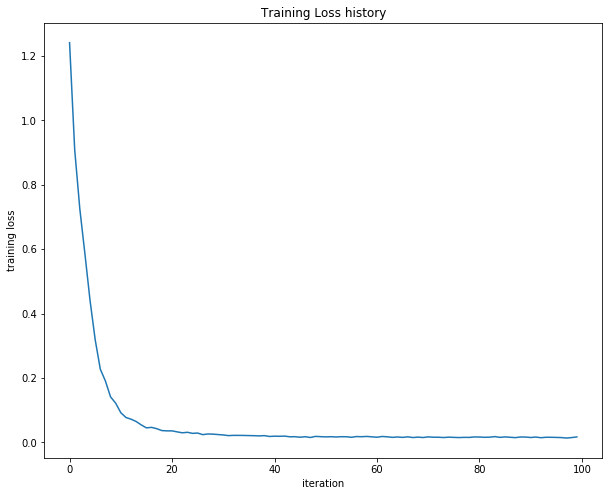

In [39]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [40]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [41]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = np.mean(net.predict(X_val) == y_val)
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302762
iteration 100 / 1000: loss 2.302347
iteration 200 / 1000: loss 2.297165
iteration 300 / 1000: loss 2.256941
iteration 400 / 1000: loss 2.199894
iteration 500 / 1000: loss 2.114171
iteration 600 / 1000: loss 2.048856
iteration 700 / 1000: loss 1.983506
iteration 800 / 1000: loss 2.002126
iteration 900 / 1000: loss 1.946782
Validation accuracy:  0.288


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

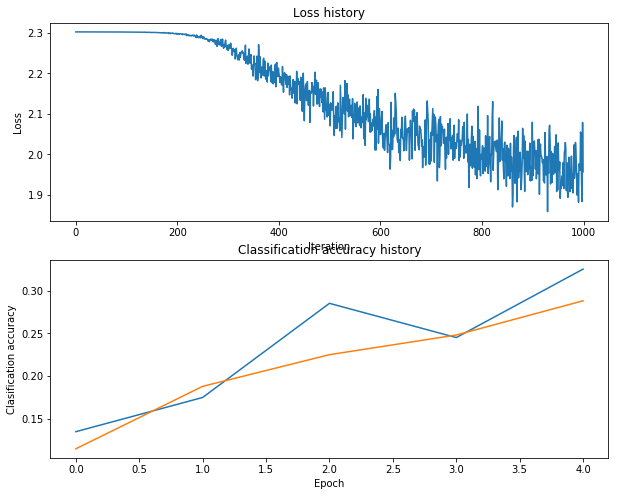

In [42]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

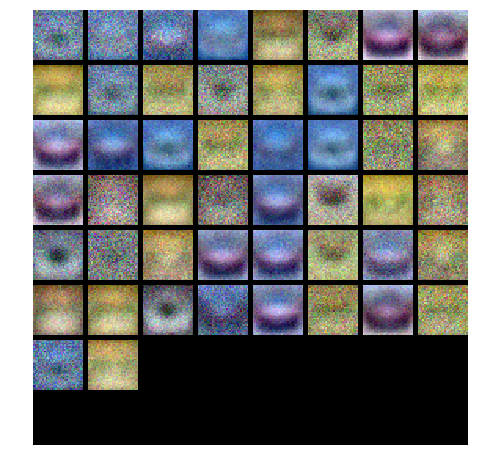

In [43]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [16]:
best_net = None # store the best model into this 
prev_acc = 0.0

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

hidden_sizes = [10, 30, 50, 60, 70, 75, 80, 90, 110]
learning_rates = [1e-4, 5e-4, 1e-5, 5e-5, 1e-6, 5e-3, 1e-3]
reg_rates = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, -0.25, -0.5]

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for reg in reg_rates:
            input_size = 32 * 32 * 3
            num_classes = 10
            net = TwoLayerNet(input_size, hidden_size, num_classes)

            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val, 
                              num_iters=2000, batch_size=200, 
                              learning_rate=lr, learning_rate_decay=0.95, reg=reg, 
                              verbose=False)

            # Predict on the validation set
            val_acc = np.mean(net.predict(X_val) == y_val)
            print('reg:', reg, 'lr:', lr, 'hidden:', hidden_size, 'Validation accuracy: ', val_acc)
            if val_acc > prev_acc:
                prev_acc = val_acc
                best_net = net
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

reg: 0.25 lr: 0.0001 hidden: 10 Validation accuracy:  0.332
reg: 0.5 lr: 0.0001 hidden: 10 Validation accuracy:  0.327
reg: 0.75 lr: 0.0001 hidden: 10 Validation accuracy:  0.338
reg: 1.0 lr: 0.0001 hidden: 10 Validation accuracy:  0.325
reg: 1.25 lr: 0.0001 hidden: 10 Validation accuracy:  0.311
reg: 1.5 lr: 0.0001 hidden: 10 Validation accuracy:  0.33
reg: -0.25 lr: 0.0001 hidden: 10 Validation accuracy:  0.316
reg: -0.5 lr: 0.0001 hidden: 10 Validation accuracy:  0.337
reg: 0.25 lr: 0.0005 hidden: 10 Validation accuracy:  0.407
reg: 0.5 lr: 0.0005 hidden: 10 Validation accuracy:  0.407
reg: 0.75 lr: 0.0005 hidden: 10 Validation accuracy:  0.413
reg: 1.0 lr: 0.0005 hidden: 10 Validation accuracy:  0.42
reg: 1.25 lr: 0.0005 hidden: 10 Validation accuracy:  0.411
reg: 1.5 lr: 0.0005 hidden: 10 Validation accuracy:  0.424
reg: -0.25 lr: 0.0005 hidden: 10 Validation accuracy:  0.412
reg: -0.5 lr: 0.0005 hidden: 10 Validation accuracy:  0.415
reg: 0.25 lr: 1e-05 hidden: 10 Validation accu

cs231n\classifiers\neural_net.py:102: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(softmax_output[range(X.shape[0]), list(y)]))
cs231n\classifiers\neural_net.py:101: RuntimeWarning: overflow encountered in exp
  softmax_output = np.exp(shift_scores) / np.sum(np.exp(shift_scores), axis=1).reshape(-1, 1)
cs231n\classifiers\neural_net.py:100: RuntimeWarning: overflow encountered in subtract
  shift_scores = scores - np.max(scores, axis=1).reshape(-1, 1)
cs231n\classifiers\neural_net.py:100: RuntimeWarning: invalid value encountered in subtract
  shift_scores = scores - np.max(scores, axis=1).reshape(-1, 1)
cs231n\classifiers\neural_net.py:79: RuntimeWarning: invalid value encountered in maximum
  hidden_layer = np.maximum(0, X.dot(W1) + b1)
cs231n\classifiers\neural_net.py:136: RuntimeWarning: invalid value encountered in less_equal
  dhidden_layer[hidden_layer <= 0] = 0
cs231n\classifiers\neural_net.py:258: RuntimeWarning: invalid value encountered in maximum

reg: 0.25 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: 0.5 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: 0.75 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: 1.0 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: 1.25 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: 1.5 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: -0.25 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: -0.5 lr: 0.005 hidden: 10 Validation accuracy:  0.087
reg: 0.25 lr: 0.001 hidden: 10 Validation accuracy:  0.402
reg: 0.5 lr: 0.001 hidden: 10 Validation accuracy:  0.405
reg: 0.75 lr: 0.001 hidden: 10 Validation accuracy:  0.419
reg: 1.0 lr: 0.001 hidden: 10 Validation accuracy:  0.425
reg: 1.25 lr: 0.001 hidden: 10 Validation accuracy:  0.41
reg: 1.5 lr: 0.001 hidden: 10 Validation accuracy:  0.407
reg: -0.25 lr: 0.001 hidden: 10 Validation accuracy:  0.408
reg: -0.5 lr: 0.001 hidden: 10 Validation accuracy:  0.414
reg: 0.25 lr: 0.0001 hidden: 30 Validation accuracy:  0.357
r

reg: 1.0 lr: 0.0005 hidden: 60 Validation accuracy:  0.487
reg: 1.25 lr: 0.0005 hidden: 60 Validation accuracy:  0.472
reg: 1.5 lr: 0.0005 hidden: 60 Validation accuracy:  0.469
reg: -0.25 lr: 0.0005 hidden: 60 Validation accuracy:  0.465
reg: -0.5 lr: 0.0005 hidden: 60 Validation accuracy:  0.477
reg: 0.25 lr: 1e-05 hidden: 60 Validation accuracy:  0.22
reg: 0.5 lr: 1e-05 hidden: 60 Validation accuracy:  0.187
reg: 0.75 lr: 1e-05 hidden: 60 Validation accuracy:  0.189
reg: 1.0 lr: 1e-05 hidden: 60 Validation accuracy:  0.209
reg: 1.25 lr: 1e-05 hidden: 60 Validation accuracy:  0.196
reg: 1.5 lr: 1e-05 hidden: 60 Validation accuracy:  0.201
reg: -0.25 lr: 1e-05 hidden: 60 Validation accuracy:  0.215
reg: -0.5 lr: 1e-05 hidden: 60 Validation accuracy:  0.223
reg: 0.25 lr: 5e-05 hidden: 60 Validation accuracy:  0.277
reg: 0.5 lr: 5e-05 hidden: 60 Validation accuracy:  0.274
reg: 0.75 lr: 5e-05 hidden: 60 Validation accuracy:  0.279
reg: 1.0 lr: 5e-05 hidden: 60 Validation accuracy:  0.27

reg: -0.5 lr: 1e-06 hidden: 75 Validation accuracy:  0.17
reg: 0.25 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: 0.5 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: 0.75 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: 1.0 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: 1.25 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: 1.5 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: -0.25 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: -0.5 lr: 0.005 hidden: 75 Validation accuracy:  0.087
reg: 0.25 lr: 0.001 hidden: 75 Validation accuracy:  0.498
reg: 0.5 lr: 0.001 hidden: 75 Validation accuracy:  0.503
reg: 0.75 lr: 0.001 hidden: 75 Validation accuracy:  0.501
reg: 1.0 lr: 0.001 hidden: 75 Validation accuracy:  0.497
reg: 1.25 lr: 0.001 hidden: 75 Validation accuracy:  0.496
reg: 1.5 lr: 0.001 hidden: 75 Validation accuracy:  0.499
reg: -0.25 lr: 0.001 hidden: 75 Validation accuracy:  0.489
reg: -0.5 lr: 0.001 hidden: 75 Validation accuracy:  0.498
re

reg: 0.75 lr: 0.0005 hidden: 110 Validation accuracy:  0.491
reg: 1.0 lr: 0.0005 hidden: 110 Validation accuracy:  0.478
reg: 1.25 lr: 0.0005 hidden: 110 Validation accuracy:  0.494
reg: 1.5 lr: 0.0005 hidden: 110 Validation accuracy:  0.473
reg: -0.25 lr: 0.0005 hidden: 110 Validation accuracy:  0.493
reg: -0.5 lr: 0.0005 hidden: 110 Validation accuracy:  0.489
reg: 0.25 lr: 1e-05 hidden: 110 Validation accuracy:  0.243
reg: 0.5 lr: 1e-05 hidden: 110 Validation accuracy:  0.184
reg: 0.75 lr: 1e-05 hidden: 110 Validation accuracy:  0.193
reg: 1.0 lr: 1e-05 hidden: 110 Validation accuracy:  0.222
reg: 1.25 lr: 1e-05 hidden: 110 Validation accuracy:  0.206
reg: 1.5 lr: 1e-05 hidden: 110 Validation accuracy:  0.199
reg: -0.25 lr: 1e-05 hidden: 110 Validation accuracy:  0.189
reg: -0.5 lr: 1e-05 hidden: 110 Validation accuracy:  0.191
reg: 0.25 lr: 5e-05 hidden: 110 Validation accuracy:  0.282
reg: 0.5 lr: 5e-05 hidden: 110 Validation accuracy:  0.281
reg: 0.75 lr: 5e-05 hidden: 110 Valida

0.524


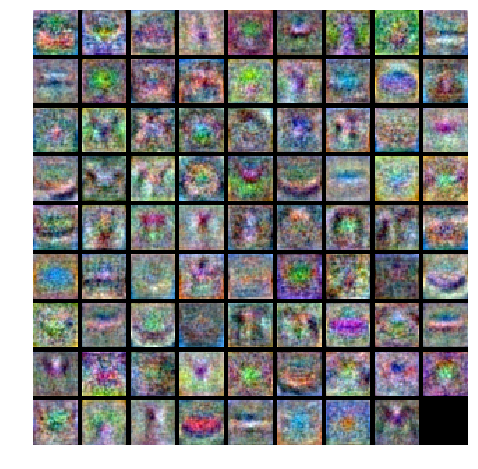

In [18]:
# visualize the weights of the best network
print(prev_acc)
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [19]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.508


In [72]:
# Best accuracy at reg: 0.25 lr: 0.001 hidden: 80 Validation accuracy:  0.524 iterations: 2000
best_params = best_net.params
best_W1 = best_params["W1"]
best_b1 = best_params["b1"]
best_W2 = best_params["W2"]
best_b2 = best_params["b2"]

iteration 0 / 2000: loss 2.302744
iteration 100 / 2000: loss 1.994349
iteration 200 / 2000: loss 1.722014
iteration 300 / 2000: loss 1.601710
iteration 400 / 2000: loss 1.702147
iteration 500 / 2000: loss 1.622058
iteration 600 / 2000: loss 1.501349
iteration 700 / 2000: loss 1.669059
iteration 800 / 2000: loss 1.210868
iteration 900 / 2000: loss 1.560228
iteration 1000 / 2000: loss 1.503330
iteration 1100 / 2000: loss 1.510325
iteration 1200 / 2000: loss 1.269955
iteration 1300 / 2000: loss 1.398692
iteration 1400 / 2000: loss 1.456538
iteration 1500 / 2000: loss 1.468659
iteration 1600 / 2000: loss 1.325540
iteration 1700 / 2000: loss 1.198527
iteration 1800 / 2000: loss 1.348184
iteration 1900 / 2000: loss 1.232094
Validation accuracy:  0.495


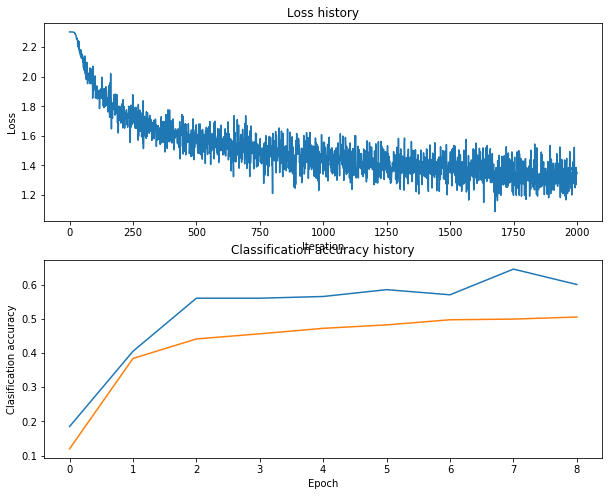

In [100]:
input_size = 32 * 32 * 3
hidden_size = 80
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=0.001, learning_rate_decay=0.95,
            reg=0.12, verbose=True)

# Predict on the validation set
val_acc = np.mean(net.predict(X_val) == y_val)
print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [99]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.511


iteration 0 / 2000: loss 2.302896
iteration 100 / 2000: loss 1.863212
iteration 200 / 2000: loss 1.657274
iteration 300 / 2000: loss 1.703867
iteration 400 / 2000: loss 1.675828
iteration 500 / 2000: loss 1.522536
iteration 600 / 2000: loss 1.561350
iteration 700 / 2000: loss 1.675933
iteration 800 / 2000: loss 1.652269
iteration 900 / 2000: loss 1.474633
iteration 1000 / 2000: loss 1.469328
iteration 1100 / 2000: loss 1.551696
iteration 1200 / 2000: loss 1.459638
iteration 1300 / 2000: loss 1.440452
iteration 1400 / 2000: loss 1.467117
iteration 1500 / 2000: loss 1.396098
iteration 1600 / 2000: loss 1.436692
iteration 1700 / 2000: loss 1.387513
iteration 1800 / 2000: loss 1.428772
iteration 1900 / 2000: loss 1.356658
Validation accuracy:  0.505


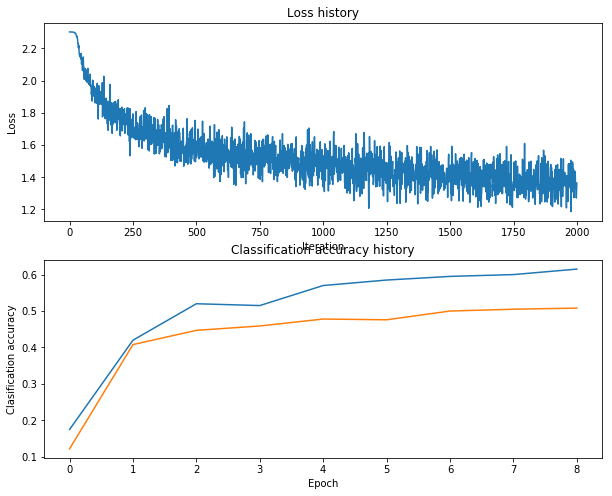

In [104]:
# Leaky ReLU
input_size = 32 * 32 * 3
hidden_size = 80
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=0.001, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = np.mean(net.predict(X_val) == y_val)
print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [105]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.516


iteration 0 / 2000: loss 2.302928
iteration 100 / 2000: loss 1.892923
iteration 200 / 2000: loss 1.810331
iteration 300 / 2000: loss 1.576895
iteration 400 / 2000: loss 1.649689
iteration 500 / 2000: loss 1.562553
iteration 600 / 2000: loss 1.557348
iteration 700 / 2000: loss 1.470479
iteration 800 / 2000: loss 1.425342
iteration 900 / 2000: loss 1.593857
iteration 1000 / 2000: loss 1.425219
iteration 1100 / 2000: loss 1.486390
iteration 1200 / 2000: loss 1.433520
iteration 1300 / 2000: loss 1.595816
iteration 1400 / 2000: loss 1.433461
iteration 1500 / 2000: loss 1.434710
iteration 1600 / 2000: loss 1.385067
iteration 1700 / 2000: loss 1.389204
iteration 1800 / 2000: loss 1.244492
iteration 1900 / 2000: loss 1.286537
Validation accuracy:  0.517


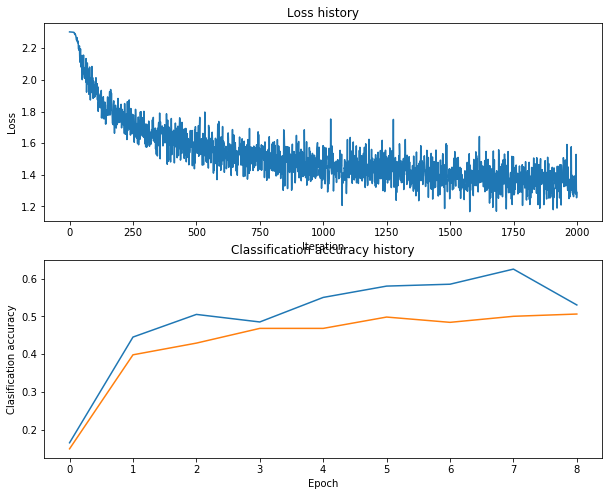

In [106]:
input_size = 32 * 32 * 3
hidden_size = 80
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=0.001, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = np.mean(net.predict(X_val) == y_val)
print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [107]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.519


In [33]:
best_net_leaky = None
best_net_leaky = list() # store the best model into this 
prev_acc = 0.0

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

hidden_sizes = [60, 70, 75, 80, 85, 90, 100, 110]
learning_rates = [5e-3, 1e-3, 1e-4, 5e-4]
reg_rates = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, -0.25, -0.5]

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for reg in reg_rates:
            input_size = 32 * 32 * 3
            num_classes = 10
            net = TwoLayerNet(input_size, hidden_size, num_classes)

            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val, 
                              num_iters=2000, batch_size=200, 
                              learning_rate=lr, learning_rate_decay=0.95, reg=reg, 
                              verbose=False)

            # Predict on the validation set
            val_acc = np.mean(net.predict(X_val) == y_val)
            print('reg:', reg, 'lr:', lr, 'hidden:', hidden_size, 'Validation accuracy: ', val_acc)
            if val_acc > 0.48:
                prev_acc = val_acc
                best_net_leaky.append(net)
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

NameError: name 'X_train' is not defined

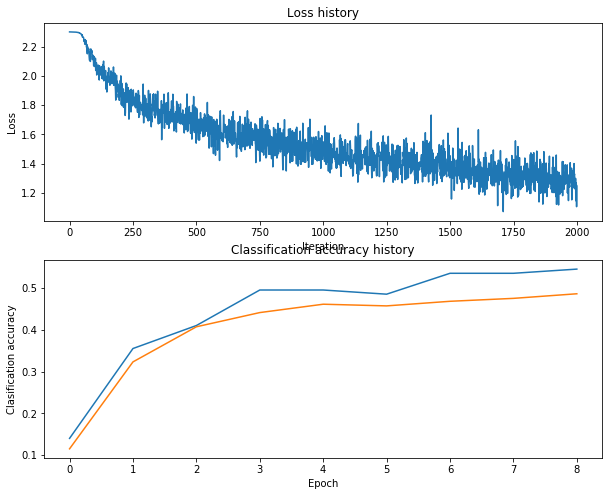

Test accuracy:  0.498


In [111]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

test_acc = (best_net_leaky.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)